<a href="https://colab.research.google.com/github/Pouyaaskari/object-detection/blob/master/object_classification_and_localization(Multi_task_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alireza-Akhavan/object-detection-notebooks.git

Cloning into 'object-detection-notebooks'...
remote: Enumerating objects: 2083, done.
remote: Counting objects: 100% (2083/2083), done.
remote: Compressing objects: 100% (2078/2078), done.
remote: Total 2083 (delta 9), reused 2069 (delta 2), pack-reused 0
Receiving objects: 100% (2083/2083), 26.78 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
%matplotlib inline

In [3]:
BASE_PATH = "/content/object-detection-notebooks/dataset2"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

In [5]:
data = []
labels = []
bboxes = []
imagePaths = []

In [6]:
csvPaths = []
for (rootDir, dirNames, filenames) in os.walk(ANNOTS_PATH):
    # loop over the filenames in the current directory
    for filename in filenames:
        # determine the file extension of the current file
        ext = filename[filename.rfind("."):].lower()

        # check to see if the file is an image and should be processed
        if ext.endswith(".csv"):
            # construct the path to the image and yield it
            csvPath = os.path.join(rootDir, filename)
            csvPaths.append(csvPath)

csvPaths

['/content/object-detection-notebooks/dataset2/annotations/airplane.csv',
 '/content/object-detection-notebooks/dataset2/annotations/motorcycle.csv',
 '/content/object-detection-notebooks/dataset2/annotations/face.csv']

In [7]:
for csvPath in csvPaths:
    # load the contents of the current CSV annotations file
    rows = open(csvPath).read().strip().split("\n")

    # loop over the rows
    for row in rows:
        # break the row into the filename, bounding box coordinates,
        # and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row

        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        imagePath = os.path.sep.join([IMAGES_PATH, label, filename])
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]

        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

In [18]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

In [19]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [20]:
print(labels)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [21]:
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [22]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [23]:
vgg.trainable = False

In [12]:
len(lb.classes_)

3

In [24]:
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

In [25]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [26]:
opt = Adam(lr=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [27]:
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}


In [28]:
history= model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=20,
    verbose=1)

Epoch 1/20
51/51 [==============================] - 55s 364ms/step - loss: 0.1971 - bounding_box_loss: 0.0127 - class_label_loss: 0.1844 - bounding_box_accuracy: 0.6310 - class_label_accuracy: 0.9287 - val_loss: 0.0026 - val_bounding_box_loss: 0.0016 - val_class_label_loss: 0.0010 - val_bounding_box_accuracy: 0.8084 - val_class_label_accuracy: 1.0000
Epoch 2/20
51/51 [==============================] - 8s 167ms/step - loss: 0.0125 - bounding_box_loss: 0.0013 - class_label_loss: 0.0112 - bounding_box_accuracy: 0.8296 - class_label_accuracy: 0.9982 - val_loss: 0.0025 - val_bounding_box_loss: 0.0012 - val_class_label_loss: 0.0013 - val_bounding_box_accuracy: 0.8280 - val_class_label_accuracy: 1.0000
Epoch 3/20
51/51 [==============================] - 9s 169ms/step - loss: 0.0083 - bounding_box_loss: 0.0010 - class_label_loss: 0.0073 - bounding_box_accuracy: 0.8733 - class_label_accuracy: 0.9982 - val_loss: 0.0013 - val_bounding_box_loss: 0.0011 - val_class_label_loss: 1.9235e-04 - val_boun

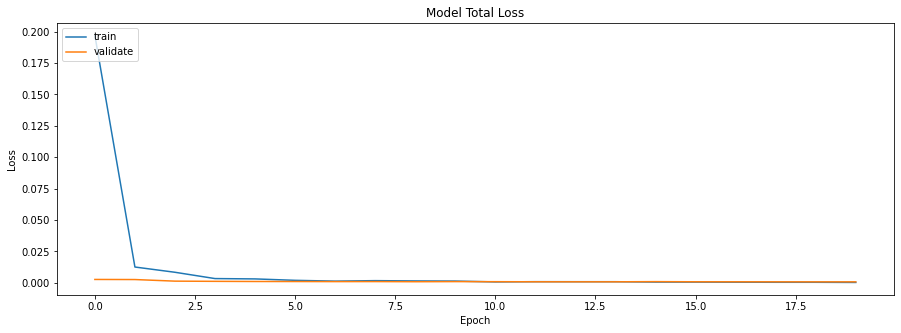

In [34]:
# summarize history for loss
fig, axs = plt.subplots(1,figsize=(15,5)) 
axs.plot(history.history['loss']) 
axs.plot(history.history['val_loss']) 
axs.set_title('Model Total Loss')
axs.set_ylabel('Loss') 
axs.set_xlabel('Epoch')
axs.legend(['train', 'validate'], loc='upper left')